# 랜덤포레스트를 이용한 예측 및 분류

## 1. 모듈 불러오기

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.formula.api import ols

import pylab

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

## 2. 데이터 불러오기: 구글 드라이브에서 users.csv 읽어오기.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
data = pd.read_csv('/content/drive/My Drive/data/users.csv')
data.head()


,user_id,gender,age,os,portfolio_type,annual_income,initial_date,initial_amount,add_amount,prior_investment,etf_knowledge,occupation,total_asset_amount,target_period,investment_priority,patience_to_loss_percentage,investment_amount,add_count,total_amount,target_count
0,BE17081900000603,male,45.0,Android,investing,60000000.0,2017.8.19,5000000.0,0,1.0,1.0,1.0,1.0,1.0,2.0,1,5000000.0,0,5000000.0,0
1,BE20171201703728,male,33.0,Android,investing,32650000.0,2018.4.23,3000000.0,200000,1.0,1.0,1.0,2.0,2.0,3.0,3,3000000.0,1,3200000.0,1
2,BE17080200000518,male,44.0,iOS,investing,75000000.0,2019.4.5,3000000.0,1470019,2.0,1.0,1.0,3.0,3.0,3.0,3,10000000.0,6,4470019.0,1
3,BE20171202685221,female,40.0,Android,multi,20000000.0,2018.5.31,6000000.0,1000000,1.0,1.0,3.0,1.0,1.0,3.0,3,1000000.0,1,7000000.0,1
4,BE17021500000061,male,31.0,Android,investing,24000000.0,2017.10.17,5000000.0,0,1.0,1.0,1.0,2.0,2.0,2.0,3,5000000.0,0,5000000.0,0


2-1 성별이 영어로 되어있어서 숫자로 바꿔줍니다.

In [31]:
data['gender'] = data['gender'].replace('male', 1)
data['gender'] = data['gender'].replace('female', 0)

data.head()

,user_id,gender,age,os,portfolio_type,annual_income,initial_date,initial_amount,add_amount,prior_investment,etf_knowledge,occupation,total_asset_amount,target_period,investment_priority,patience_to_loss_percentage,investment_amount,add_count,total_amount,target_count
0,BE17081900000603,1,45.0,Android,investing,60000000.0,2017.8.19,5000000.0,0,1.0,1.0,1.0,1.0,1.0,2.0,1,5000000.0,0,5000000.0,0
1,BE20171201703728,1,33.0,Android,investing,32650000.0,2018.4.23,3000000.0,200000,1.0,1.0,1.0,2.0,2.0,3.0,3,3000000.0,1,3200000.0,1
2,BE17080200000518,1,44.0,iOS,investing,75000000.0,2019.4.5,3000000.0,1470019,2.0,1.0,1.0,3.0,3.0,3.0,3,10000000.0,6,4470019.0,1
3,BE20171202685221,0,40.0,Android,multi,20000000.0,2018.5.31,6000000.0,1000000,1.0,1.0,3.0,1.0,1.0,3.0,3,1000000.0,1,7000000.0,1
4,BE17021500000061,1,31.0,Android,investing,24000000.0,2017.10.17,5000000.0,0,1.0,1.0,1.0,2.0,2.0,2.0,3,5000000.0,0,5000000.0,0


In [32]:
#data = data.drop(columns=['aim_id','os', 'initial_date'])
data['portfolio_type'] = data['portfolio_type'].replace('investing', 0)
data['portfolio_type'] = data['portfolio_type'].replace('saving', 1)
data['portfolio_type'] = data['portfolio_type'].replace('multi', 2)
data.head()

,user_id,gender,age,os,portfolio_type,annual_income,initial_date,initial_amount,add_amount,prior_investment,etf_knowledge,occupation,total_asset_amount,target_period,investment_priority,patience_to_loss_percentage,investment_amount,add_count,total_amount,target_count
0,BE17081900000603,1,45.0,Android,0,60000000.0,2017.8.19,5000000.0,0,1.0,1.0,1.0,1.0,1.0,2.0,1,5000000.0,0,5000000.0,0
1,BE20171201703728,1,33.0,Android,0,32650000.0,2018.4.23,3000000.0,200000,1.0,1.0,1.0,2.0,2.0,3.0,3,3000000.0,1,3200000.0,1
2,BE17080200000518,1,44.0,iOS,0,75000000.0,2019.4.5,3000000.0,1470019,2.0,1.0,1.0,3.0,3.0,3.0,3,10000000.0,6,4470019.0,1
3,BE20171202685221,0,40.0,Android,2,20000000.0,2018.5.31,6000000.0,1000000,1.0,1.0,3.0,1.0,1.0,3.0,3,1000000.0,1,7000000.0,1
4,BE17021500000061,1,31.0,Android,0,24000000.0,2017.10.17,5000000.0,0,1.0,1.0,1.0,2.0,2.0,2.0,3,5000000.0,0,5000000.0,0


# 3. 범주형 데이터 처리 및 필요없는 데이터 빼기

In [33]:
occupation_dummy = pd.get_dummies(data['occupation'], drop_first=True)
occupation_dummy.columns = ['occupation_1','occupation_2','occupation_3','occupation_4']

In [34]:
investment_priority_dummy = pd.get_dummies(data['investment_priority'], drop_first=True)
investment_priority_dummy.columns = ['investment_priority_1', 'investment_priority_2', 'investment_priority_3', 'investment_priority_4']

In [35]:
patience_to_loss_percentage_dummy = pd.get_dummies(data['patience_to_loss_percentage'], drop_first=True)
patience_to_loss_percentage_dummy.columns = ['patience_to_loss_percentage_1', 'patience_to_loss_percentage_2', 'patience_to_loss_percentage_3', 'patience_to_loss_percentage_4']

In [36]:
target_period_dummy = pd.get_dummies(data['target_period'], drop_first=True)
target_period_dummy.columns = ['target_period_1','target_period_2']

In [37]:
total_asset_amount_dummy = pd.get_dummies(data['total_asset_amount'], drop_first=True)
total_asset_amount_dummy.columns = ['total_asset_amount_1','total_asset_amount_2','total_asset_amount_3','total_asset_amount_4']

In [38]:
# 포트폴리오 타입 더미
portfolio_type_dummy = pd.get_dummies(data['portfolio_type'], drop_first=True)
portfolio_type_dummy.columns = ['portfolio_type_1', 'portfolio_type_2']

In [39]:
# prior_investment_dummy 타입 더미
prior_investment_dummy = pd.get_dummies(data['prior_investment'], drop_first=True)
prior_investment_dummy.columns = ['prior_investment_1', 'prior_investment_2','prior_investment_3']

In [40]:
data = data.drop(columns=['portfolio_type','add_amount', 'prior_investment','occupation','total_asset_amount','target_period','investment_priority','patience_to_loss_percentage'])
data.head()

,user_id,gender,age,os,annual_income,initial_date,initial_amount,etf_knowledge,investment_amount,add_count,total_amount,target_count
0,BE17081900000603,1,45.0,Android,60000000.0,2017.8.19,5000000.0,1.0,5000000.0,0,5000000.0,0
1,BE20171201703728,1,33.0,Android,32650000.0,2018.4.23,3000000.0,1.0,3000000.0,1,3200000.0,1
2,BE17080200000518,1,44.0,iOS,75000000.0,2019.4.5,3000000.0,1.0,10000000.0,6,4470019.0,1
3,BE20171202685221,0,40.0,Android,20000000.0,2018.5.31,6000000.0,1.0,1000000.0,1,7000000.0,1
4,BE17021500000061,1,31.0,Android,24000000.0,2017.10.17,5000000.0,1.0,5000000.0,0,5000000.0,0


In [41]:
data = data.drop(columns=['user_id','os','initial_date', 'gender'])

In [42]:
data = pd.concat([data,occupation_dummy, investment_priority_dummy, patience_to_loss_percentage_dummy, target_period_dummy, total_asset_amount_dummy, portfolio_type_dummy, prior_investment_dummy  ], axis=1)
data.head()


,age,annual_income,initial_amount,etf_knowledge,investment_amount,add_count,total_amount,target_count,occupation_1,occupation_2,occupation_3,occupation_4,investment_priority_1,investment_priority_2,investment_priority_3,investment_priority_4,patience_to_loss_percentage_1,patience_to_loss_percentage_2,patience_to_loss_percentage_3,patience_to_loss_percentage_4,target_period_1,target_period_2,total_asset_amount_1,total_asset_amount_2,total_asset_amount_3,total_asset_amount_4,portfolio_type_1,portfolio_type_2,prior_investment_1,prior_investment_2,prior_investment_3
0,45.0,60000000.0,5000000.0,1.0,5000000.0,0,5000000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33.0,32650000.0,3000000.0,1.0,3000000.0,1,3200000.0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
2,44.0,75000000.0,3000000.0,1.0,10000000.0,6,4470019.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
3,40.0,20000000.0,6000000.0,1.0,1000000.0,1,7000000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,31.0,24000000.0,5000000.0,1.0,5000000.0,0,5000000.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


In [43]:
from sklearn.model_selection import train_test_split
data = data.fillna(0)
data = data.drop(columns=['add_count' ])
train_data, test_data = train_test_split(data, test_size = 0.3, random_state=55)


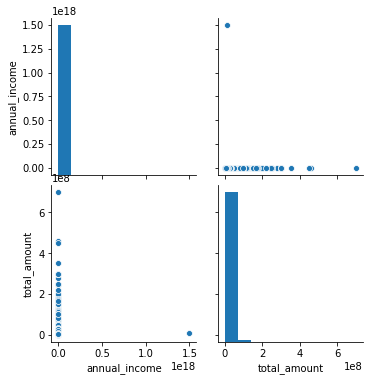

In [44]:
data['annual_income'] = data['annual_income']/10

sns.pairplot(data[['annual_income', 'total_amount']])
plt.show()

In [45]:
data['total_amount']

0         5000000.0
1         3200000.0
2         4470019.0
3         7000000.0
4         5000000.0
            ...    
10887    10000000.0
10888     5000000.0
10889     3000000.0
10890     3000000.0
10891     5000000.0
Name: total_amount, Length: 10892, dtype: float64

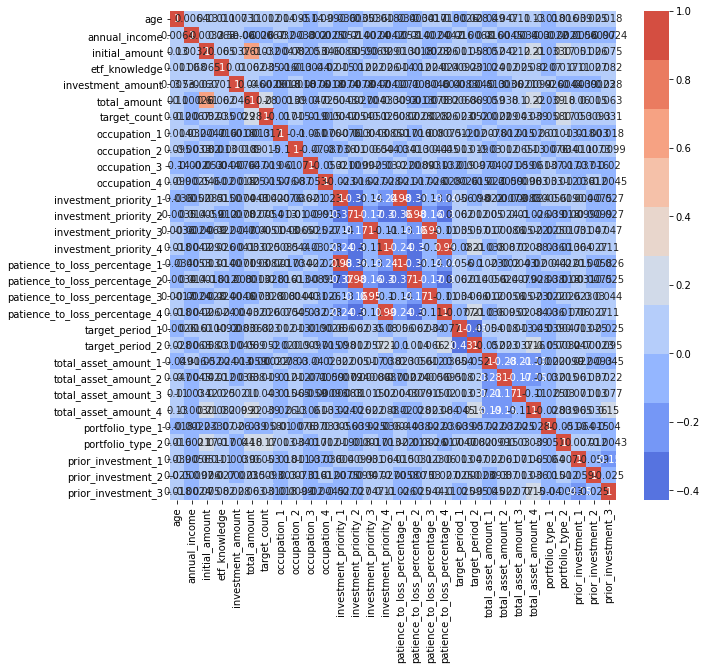

In [46]:
plt.figure(figsize=(10, 9))
sns.heatmap(data.corr(), cmap=sns.color_palette("coolwarm", 10), annot=True)

In [47]:
# x 인풋데이터
# y target_count 1 : 추가투자 한 고객. 0 : 추가투자 안한 고객
# y2 total_amount 총 투자 금액
train_data_x = train_data.drop(columns=['target_count','total_amount'])
train_data_y = train_data['target_count']
train_data_y2 = train_data['total_amount']

test_data_x =  test_data.drop(columns=['target_count','total_amount'])
test_data_y =  test_data['target_count']
test_data_y2 = test_data['total_amount']

In [48]:
test_data_x

,age,annual_income,initial_amount,etf_knowledge,investment_amount,occupation_1,occupation_2,occupation_3,occupation_4,investment_priority_1,investment_priority_2,investment_priority_3,investment_priority_4,patience_to_loss_percentage_1,patience_to_loss_percentage_2,patience_to_loss_percentage_3,patience_to_loss_percentage_4,target_period_1,target_period_2,total_asset_amount_1,total_asset_amount_2,total_asset_amount_3,total_asset_amount_4,portfolio_type_1,portfolio_type_2,prior_investment_1,prior_investment_2,prior_investment_3
7174,44.0,7500000.0,5000000.0,1.0,10000000.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
7690,29.0,75000000.0,5000000.0,1.0,5000000.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2589,48.0,75000000.0,5000000.0,1.0,5000000.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
747,31.0,40000000.0,3000000.0,1.0,5000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5557,54.0,172500000.0,10000000.0,1.0,10000000.0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,23.0,35000000.0,3000000.0,1.0,3000000.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
5381,34.0,75000000.0,9994390.0,1.0,6980000.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4884,33.0,172500000.0,5000000.0,1.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
7263,38.0,75000000.0,3000000.0,1.0,10000000.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [58]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score, mean_squared_error
rf = RandomForestClassifier(random_state=2019)
rf.fit(train_data_x, train_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2019,
                       verbose=0, warm_start=False)

In [59]:
prod_y = rf.predict(test_data_x)

In [60]:
accuracy_score(prod_y, test_data_y)


0.6566707466340269

In [62]:
rf2 = RandomForestRegressor(random_state=2020)
rf2.fit(train_data_x, train_data_y2)
prod_y = rf2.predict(test_data_x)


In [63]:
r2_score(test_data_y2, prod_y)

0.3106707488545064

In [64]:
prod_y

array([11577799.84,  5433037.86,  5000000.  , ..., 13192607.56,
        4225375.  ,  5387000.  ])

In [65]:
mean_squared_error(test_data_y2, prod_y)

208610334701621.97

In [66]:
rf2.feature_importances_

array([0.13022767, 0.08503075, 0.40566859, 0.00542759, 0.11487433,
       0.02165412, 0.02536504, 0.00093389, 0.00355957, 0.01164722,
       0.01195552, 0.00434052, 0.00558371, 0.01531551, 0.0168045 ,
       0.0032576 , 0.0060843 , 0.01972453, 0.0179905 , 0.00524436,
       0.01227138, 0.00778437, 0.02392434, 0.00794247, 0.00921847,
       0.01621365, 0.00159491, 0.0103606 ])